In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable as var
from torch.nn import functional as F
import torchtext.vocab as vocab
from tqdm import tqdm
from pprint import pprint
import json
import _pickle as pkl

In [14]:
glove = vocab.GloVe(name='6B', dim=50)

In [15]:
def clean(token):
    cleaned_token = token.strip(".,?!-:;'()[]\"`")
    if cleaned_token[-2:] == "'s":
        cleaned_token = cleaned_token[:-2]
    if cleaned_token[-2:] == "'t":
        cleaned_token = cleaned_token[:-2]+'t'
    return cleaned_token

def get_vector(word):
    return glove.vectors[glove.stoi[word]]

glove.stoi['<unk>'] = len(glove.stoi)+1 # add token->index for unknown/oov
glove.vectors = torch.cat((glove.vectors, torch.zeros(1, 50))) # add index->vec for unknown/oov

def vectorize(input_txt, only_idx=False):
    input_seq = [clean(w) for w in input_txt if len(clean(w).strip())]
    glove_vec = []
    if only_idx:
        for w in input_seq:
            try:
                glove_vec.append(glove.stoi[w])
            except:
                glove_vec.append(400000)
        return torch.LongTensor(glove_vec[:200])
    else:
        glove_vec = [get_vector(w).tolist() for w in input_seq]
        return torch.FloatTensor(glove_vec[:200])

In [16]:
with open('../data/data.json', 'r') as f:
    data = json.load(f)

In [17]:
print(glove.vectors.size())

torch.Size([400001, 50])


In [18]:
idx = 5
example_X = (data['X_train'][idx])
example_y = (data['y_train'][idx])
print("Context:", example_X[0])
print("Question:", example_X[1])
print("Answer Span:", example_y)
print("Answer:", example_X[0][example_y[0]:example_y[1]])
X = vectorize(example_X[0].lower())

Context: The storage in sensory memory and short-term memory generally has a strictly limited capacity and duration, which means that information is not retained indefinitely. By contrast, long-term memory can store much larger quantities of information for potentially unlimited duration (sometimes a whole life span). Its capacity is immeasurable. For example, given a random seven-digit number we may remember it for only a few seconds before forgetting, suggesting it was stored in our short-term memory. On the other hand, we can remember telephone numbers for many years through repetition; this information is said to be stored in long-term memory.
Question: Why can't some memories be held onto forever?
Answer Span: [0, 106]
Answer: The storage in sensory memory and short-term memory generally has a strictly limited capacity and duration


In [19]:
def make_data(raw_X):
    X = []
    for (c, q, _) in raw_X:
        context_rep = vectorize(c.lower(), only_idx=True)
        ques_rep = vectorize(q.lower(), only_idx=True)
        X.append(context_rep) #only context for now
    return X
X_pass = make_data(data['X_train'][:20])
y_pass = data['y_train'][:20]

In [20]:
class ModelV1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size, n_layers=1, opt='adam', lr=1e-3, epochs=5, emb_dim=50):
        super(ModelV1, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        
        if opt == 'adam':
            self.opt = optim.Adam
        else:
            self.opt = optim.SGD
        self.lr = lr
        self.epochs = epochs
        self.emb_dim = emb_dim
        
        self.encoder = nn.Embedding(len(glove.vectors), self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_size, self.n_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        self.init_weights()
    
    def init_weights(self):
        weight_scale = 0.01
        self.encoder.weight.data = glove.vectors
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-weight_scale, weight_scale)
    
    def init_hidden(self, batch_size=1):
        weight = next(self.parameters()).data
        return var(weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_())
        
    def forward(self, inputs, hidden):
        inputs = inputs[0]
        embeds = self.encoder(var(inputs)) # get glove repr
        
        lstm_op, (hnext, cnext) = self.lstm(embeds, hidden)
        last = lstm_op[-1]
        out = self.decoder(last)
        return out, (hnext, cnext)

    def fit(self, X, y):
        opt = self.opt(self.parameters(), self.lr)
        losses = []
        for epoch in tqdm(range(5)):
            bs = 1
            tloss = 0.0
            for i in range(0, len(y)-bs+1, bs):
                h, c = self.init_hidden(), self.init_hidden()
                opt.zero_grad()
                Xb = X[i:i+bs]
                yb = var(torch.FloatTensor(y[i:i+bs]))
                pred, (h, c) = self.forward(Xb, (h, c)) #prediction on batch features
                loss = F.mse_loss(pred, yb)
                tloss += loss.data[0]
                loss.backward()
                opt.step()
            losses.append(tloss)
        self.hidden = (h, c)
        return losses

    def predict(self, X):
        return self.forward(X, self.hidden)[0]

In [21]:
model = ModelV1(200, 100, 2, batch_size=1, epochs=2)

In [22]:
res = model.fit(X_pass, y_pass)

100%|██████████| 5/5 [00:54<00:00, 10.95s/it]


In [23]:
model.predict([X_pass[2]])

Variable containing:
 9.1203  9.4992
[torch.FloatTensor of size 1x2]

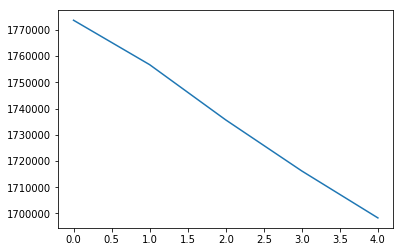

In [24]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(res))), res)
plt.show()